In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scikits.odes.ode import ode
import time
import random

In [3]:
#Import local functions
sys.path.append('../functions')
from functions import nonlinearity, repression, activation

In [4]:
def solve_point(x):
    n1, n2, theta1, theta2, k1, k2 = x
    
    alpha1 = 1E-5
    alpha2 = 1E-2

    int_time = 5E4
    t = np.linspace(0, int_time, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

    def dual_control_sundials(t, y, ydot):
        kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
        ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

    def loss_biological(j1, j2, alpha1, alpha2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss
        
    solution = ode('cvode', dual_control_sundials, old_api=False).solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1, alpha2=alpha2)
    return loss

In [5]:
def solve_patch_6d(init_conds, patch_size, step_sizes):
    n1, n2, theta1, theta2, k1, k2 = init_conds
    center_loss = solve_point(init_conds)
    #Sample randomly from hypersphere
    normal_deviates = np.random.normal(size=(6, patch_size))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius

    scaled_points = []
    for i in range(patch_size):
        scaled_points.append(list(step_sizes*points[:, i]  + init_conds))
    scaled_points = np.array(scaled_points)
    
    min_loss = center_loss
    new_k1 = k1; new_k2 = k2; new_theta1 = theta1; new_theta2 = theta2; new_n1 = n1; new_n2 = n2
    for n1, n2, theta1, theta2, k1, k2 in zip(scaled_points[:, 0], scaled_points[:, 1], scaled_points[:, 2], scaled_points[:, 3], scaled_points[:, 4], scaled_points[:, 5]):
        loss = solve_point([n1, n2, theta1, theta2, k1, k2])
        if bounds_check_6d(n1, n2, theta1, theta2, k1, k2):
            if loss < min_loss:
                new_k1 = k1
                new_k2 = k2
                new_theta1 = theta1
                new_theta2 = theta2
                new_n1 = n1
                new_n2 = n2
                min_loss = loss
    return new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, min_loss

In [6]:
def bounds_check_6d(n1, n2, theta1, theta2, k1, k2):
    if k1 <= 1E-3 and k2 <= 1E-3 and k1 >= 1E-7 and k2 >= 1E-7:
        if n1 <= 4 and n2 <= 4 and n1 >= 1 and n2 >= 1:
            if theta1 >= 0.001 and theta2 >= 0.001 and theta1 <= 10 and theta2 <= 10:
                return True
    else: return False

In [7]:
def gen_ics(N):
    #Set random seed
    np.random.seed(2022)
    ics = []
    for i in range(N):
        k1 = random.uniform(1E-7,1E-3)
        k2 = random.uniform(1E-7,1E-3)
        n1 = random.uniform(1,4)
        n2 = random.uniform(1,4)
        theta1 = random.uniform(0.001,10)
        theta2 = random.uniform(0.001,10)

        init_conds = np.array([n1,n2,theta1, theta2, k1, k2])
        ics.append(init_conds)
    return ics

#Randomize N=10 initial conditions 
ics = gen_ics(50)

In [63]:
#Set hyperparameters
num_epochs = 100
tolerance = 0.0004
patch_size = 100
step_sizes = np.array([0.1, 0.1, 0.01, 0.01, 0.0001, 0.0001])

In [64]:
list_of_results = []
for i in range(len(ics)):
    print('Descent', i+1, 'of', len(ics))
    init_conds = ics[i]
    solve_patch_6d(init_conds, patch_size, step_sizes)
    next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2, loss = solve_patch_6d(init_conds, patch_size, step_sizes)

    losses = [loss]; k1_trace = [next_k1]; k2_trace = [next_k2]; n1_trace = [next_n1]; n2_trace = [next_n2]; theta1_trace = [next_theta1]; theta2_trace = [next_theta2]

    for i in range(num_epochs):
        new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, loss = solve_patch_6d([next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2], patch_size, step_sizes)
        next_k1 = new_k1
        next_k2 = new_k2
        next_theta1 = new_theta1
        next_theta2 = new_theta2
        next_n1 = new_n1
        next_n2 = new_n2

        print('Epoch: ', i, 'Loss: ', loss)
        losses.append(loss)
        k1_trace.append(new_k1)
        k2_trace.append(new_k2)
        n1_trace.append(new_n1)
        n2_trace.append(new_n2)
        theta1_trace.append(new_theta1)
        theta2_trace.append(new_theta2)

        if losses[-2] - losses[-1] < tolerance:
            print('Terminating early at step', i, 'of ', num_epochs)
            break
    results = pd.DataFrame({'loss':losses,'k1_trace':k1_trace,'k2_trace':k2_trace,'n1_trace':n1_trace,'n2_trace':n2_trace,'theta1_trace':theta1_trace, 'theta2_trace':theta2_trace})
    list_of_results.append(results)


Descent 1 of 50
Epoch:  0 Loss:  0.04446729136225745
Epoch:  1 Loss:  0.04406204499651664
Epoch:  2 Loss:  0.04362336314957898
Epoch:  3 Loss:  0.04362336314957898
Terminating early at step 3 of  100
Descent 2 of 50
Epoch:  0 Loss:  21.9043390997044
Epoch:  1 Loss:  12.750014306589497
Epoch:  2 Loss:  5.450799256784293
Epoch:  3 Loss:  0.4052852369415653
Epoch:  4 Loss:  0.042245832152453575
Epoch:  5 Loss:  0.04175880330208404
Epoch:  6 Loss:  0.04163843281872917
Terminating early at step 6 of  100
Descent 3 of 50


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.15939265617285855
Terminating early at step 0 of  100
Descent 4 of 50
Epoch:  0 Loss:  129.2012353538659
Epoch:  1 Loss:  109.14138408100754
Epoch:  2 Loss:  91.21830875336127
Epoch:  3 Loss:  73.28740731263156
Epoch:  4 Loss:  58.174559537036124
Epoch:  5 Loss:  44.996258104302406
Epoch:  6 Loss:  32.95762976352098
Epoch:  7 Loss:  22.182293936096862
Epoch:  8 Loss:  12.099570550984875
Epoch:  9 Loss:  2.617059024213576



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.06271191626846537



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06259079016024105
Terminating early at step 11 of  100
Descent 5 of 50
Epoch:  0 Loss:  11.672620541645227
Epoch:  1 Loss:  5.008374469398689
Epoch:  2 Loss:  0.2204067428876351
Epoch:  3 Loss:  0.04317749048373454
Epoch:  4 Loss:  0.0424229337901879
Epoch:  5 Loss:  0.0423108397552257
Terminating early at step 5 of  100
Descent 6 of 50
Epoch:  0 Loss:  0.04467907191003194
Epoch:  1 Loss:  0.044140325475816616
Epoch:  2 Loss:  0.044140325475816616
Terminating early at step 2 of  100
Descent 7 of 50



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.06651704491240856
Terminating early at step 0 of  100
Descent 8 of 50
Epoch:  0 Loss:  15.800929949038073
Epoch:  1 Loss:  10.621891240447976
Epoch:  2 Loss:  5.598094640431033
Epoch:  3 Loss:  1.8371911884749124
Epoch:  4 Loss:  0.0436685073803879
Epoch:  5 Loss:  0.0436685073803879
Terminating early at step 5 of  100
Descent 9 of 50
Epoch:  0 Loss:  182.1237170849218
Epoch:  1 Loss:  150.93855738006295
Epoch:  2 Loss:  124.21585385697696
Epoch:  3 Loss:  98.22192568520965
Epoch:  4 Loss:  76.44833988797103
Epoch:  5 Loss:  57.180465188434894
Epoch:  6 Loss:  39.470104606241605
Epoch:  7 Loss:  22.583448916465823
Epoch:  8 Loss:  9.069707853397253
Epoch:  9 Loss:  0.6405508665833866
Epoch:  10 Loss:  0.04272931903935796
Epoch:  11 Loss:  0.04272931903935796
Terminating early at step 11 of  100
Descent 10 of 50
Epoch:  0 Loss:  0.23261415567942625
Epoch:  1 Loss:  0.20248454259565088
Epoch:  2 Loss:  0.17254099078736176
Epoch:  3 Loss:  0.14721035804656618
Epoch:  4 


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.08019083600177368



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.07715665173247216



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07350223210645968



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06737900337387315



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.060391365583401205



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.04485169624550181



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.04485169624550181
Terminating early at step 6 of  100
Descent 12 of 50
Epoch:  0 Loss:  0.059858781514953614
Epoch:  1 Loss:  0.058255537328057515
Epoch:  2 Loss:  0.05683709027510092
Epoch:  3 Loss:  0.055708449823744816
Epoch:  4 Loss:  0.054504842329468506
Epoch:  5 Loss:  0.05407312031074922
Epoch:  6 Loss:  0.05298201333943664
Epoch:  7 Loss:  0.05227822516964177
Epoch:  8 Loss:  0.05165257750811837
Epoch:  9 Loss:  0.05098625623585415
Epoch:  10 Loss:  0.05015364457697048
Epoch:  11 Loss:  0.0499229836947367
Terminating early at step 11 of  100
Descent 13 of 50
Epoch:  0 Loss:  0.043850812178853255
Epoch:  1 Loss:  0.0435046221078888
Terminating early at step 1 of  100
Descent 14 of 50
Epoch:  0 Loss:  0.06964153404661308
Epoch:  1 Loss:  0.06806924996119419
Epoch:  2 Loss:  0.06669756186363544
Epoch:  3 Loss:  0.0657085560818361
Epoch:  4 Loss:  0.06398174331356757
Epoch:  5 Loss:  0.0618312954669792
Epoch:  6 Loss:  0.05957120542429094
Epoch:  7 Loss:  0.0566


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08733053702742608



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.08447720125458



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07460198174339358



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06987827068181304



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.04709584962219983



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.04519039261770176
Epoch:  13 Loss:  0.044132309945199205
Epoch:  14 Loss:  0.04351336780256826
Epoch:  15 Loss:  0.042517868805907105
Epoch:  16 Loss:  0.042517868805907105
Terminating early at step 16 of  100
Descent 18 of 50



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.08445342968195826



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.08119960374361042



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.08119960374361042
Terminating early at step 2 of  100
Descent 19 of 50
Epoch:  0 Loss:  0.044091454456699465
Epoch:  1 Loss:  0.043951839542395565
Terminating early at step 1 of  100
Descent 20 of 50
Epoch:  0 Loss:  3.7688380796946
Epoch:  1 Loss:  0.07349859360652344



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07069892708069622



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.0652367022819787



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.05988596392616374



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.05674381939260238



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.044390378821109425
Epoch:  7 Loss:  0.043630510189908905
Epoch:  8 Loss:  0.04317599939271909
Epoch:  9 Loss:  0.04286283001782412
Terminating early at step 9 of  100
Descent 21 of 50
Epoch:  0 Loss:  38.40313722479521
Epoch:  1 Loss:  20.965832742233925
Epoch:  2 Loss:  8.839977857198736
Epoch:  3 Loss:  1.0423166503707673



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06659627208076074



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06640802344047664
Terminating early at step 5 of  100
Descent 22 of 50
Epoch:  0 Loss:  0.052354154868424436
Epoch:  1 Loss:  0.05150254718097956
Epoch:  2 Loss:  0.0507344203697033
Epoch:  3 Loss:  0.05016822691209285
Epoch:  4 Loss:  0.04953651660035269
Epoch:  5 Loss:  0.04937001441851696
Terminating early at step 5 of  100
Descent 23 of 50
Epoch:  0 Loss:  2.889041259662896
Epoch:  1 Loss:  1.2718005263152845
Epoch:  2 Loss:  0.1817361018767702
Epoch:  3 Loss:  0.05480959501713045
Epoch:  4 Loss:  0.05444725282388681
Terminating early at step 4 of  100
Descent 24 of 50
Epoch:  0 Loss:  26.905117276413627
Epoch:  1 Loss:  21.373897579044698
Epoch:  2 Loss:  17.03327751567154
Epoch:  3 Loss:  12.888369471755562
Epoch:  4 Loss:  9.057097914640492
Epoch:  5 Loss:  5.931723310241064
Epoch:  6 Loss:  3.533615678918429
Epoch:  7 Loss:  1.6616579876720248
Epoch:  8 Loss:  0.3081489627632795
Epoch:  9 Loss:  0.04571425946914148
Epoch:  10 Loss:  0.045501642722760166
Termi


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.23267140682239826



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.22905672951549128



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.22626944088278605



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.21611756399587964



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.2123302723722918



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.20496885715553584



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.20076529305662044



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.1965346267497286



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.19305757898899784



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.18003305708919431



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.16587842736404115



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.15957707113704825



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.13506664517721303



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.13506664517721303
Terminating early at step 14 of  100
Descent 27 of 50



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.06694156283594589



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.06493560791354264
Epoch:  2 Loss:  0.061090563390697045
Epoch:  3 Loss:  0.05837979725455476
Epoch:  4 Loss:  0.05622049214782833
Epoch:  5 Loss:  0.05537439498219512
Epoch:  6 Loss:  0.05416297874599067
Epoch:  7 Loss:  0.053759252351555
Epoch:  8 Loss:  0.053042088359612535
Epoch:  9 Loss:  0.05265955775244635
Terminating early at step 9 of  100
Descent 28 of 50
Epoch:  0 Loss:  0.04616302138860187
Terminating early at step 0 of  100
Descent 29 of 50
Epoch:  0 Loss:  12.740604214351123
Epoch:  1 Loss:  0.32488329641767183



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.10535584944258825



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.1047758849046763



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.10082148767429769



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.0989612946925511



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.09579064728982499



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09432965922947424



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.09432965922947424
Terminating early at step 8 of  100
Descent 30 of 50



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.10161170368336508
Epoch:  1 Loss:  0.08060532872834408
Epoch:  2 Loss:  0.078309364624775
Epoch:  3 Loss:  0.07646638688627322
Epoch:  4 Loss:  0.07484601453789295
Epoch:  5 Loss:  0.07222175010730966
Epoch:  6 Loss:  0.06964411865087908
Epoch:  7 Loss:  0.06709273077669355
Epoch:  8 Loss:  0.065110511447547
Epoch:  9 Loss:  0.06345301687463045
Epoch:  10 Loss:  0.060701001329119056
Epoch:  11 Loss:  0.059167881895923494
Epoch:  12 Loss:  0.05735914474364628
Epoch:  13 Loss:  0.05656065412471311
Epoch:  14 Loss:  0.05465215336225365
Epoch:  15 Loss:  0.05353176713318886
Epoch:  16 Loss:  0.05328387926795567
Terminating early at step 16 of  100
Descent 31 of 50
Epoch:  0 Loss:  0.9171192728064408
Epoch:  1 Loss:  0.04113094501187175
Epoch:  2 Loss:  0.04113094501187175
Terminating early at step 2 of  100
Descent 32 of 50
Epoch:  0 Loss:  0.043030062454228024
Epoch:  1 Loss:  0.04209267861152029
Epoch:  2 Loss:  0.041967699487714887
Terminating early at step 2 of  100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.1010501693437163



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09744838055566843



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.09481420165333353



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08937641229925282



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.0886591933071104



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.08601767873030682



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.08601767873030682
Terminating early at step 12 of  100
Descent 34 of 50
Epoch:  0 Loss:  34.357779651181595
Epoch:  1 Loss:  26.15025839994215
Epoch:  2 Loss:  18.70905025767473
Epoch:  3 Loss:  11.49407106463612
Epoch:  4 Loss:  5.965535894914832
Epoch:  5 Loss:  1.757237461341019
Epoch:  6 Loss:  0.04333283238118529
Epoch:  7 Loss:  0.042867735026186765
Epoch:  8 Loss:  0.042867735026186765
Terminating early at step 8 of  100
Descent 35 of 50
Epoch:  0 Loss:  8.067733184960808
Epoch:  1 Loss:  5.311451765807094
Epoch:  2 Loss:  3.1845230565139513
Epoch:  3 Loss:  1.4015134935431495
Epoch:  4 Loss:  0.22552108208248683
Epoch:  5 Loss:  0.054757928653451915
Epoch:  6 Loss:  0.05411777757422998
Epoch:  7 Loss:  0.054069189792583516
Terminating early at step 7 of  100
Descent 36 of 50
Epoch:  0 Loss:  114.45077434908514
Epoch:  1 Loss:  90.27767354060262
Epoch:  2 Loss:  65.83623871122283
Epoch:  3 Loss:  43.57366015727058
Epoch:  4 Loss:  24.072139814430628
Epoch:  5


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.07474318860133929
Terminating early at step 0 of  100
Descent 42 of 50
Epoch:  0 Loss:  0.04811801827270493
Terminating early at step 0 of  100
Descent 43 of 50
Epoch:  0 Loss:  0.04277304328521071
Epoch:  1 Loss:  0.042511933468836645
Terminating early at step 1 of  100
Descent 44 of 50
Epoch:  0 Loss:  0.04379410921544975
Epoch:  1 Loss:  0.04379410921544975
Terminating early at step 1 of  100
Descent 45 of 50
Epoch:  0 Loss:  1.6274033180169287
Epoch:  1 Loss:  0.04715139684655754
Epoch:  2 Loss:  0.04715139684655754
Terminating early at step 2 of  100
Descent 46 of 50



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.15001792723295895



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.14719866628955236


 = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1

Epoch:  2 Loss:  0.14613027828127595



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.14278228938979565



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.138478504139961



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.138478504139961
Terminating early at step 5 of  100
Descent 47 of 50



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.06266888578688362
Epoch:  1 Loss:  0.06205401795710315
Epoch:  2 Loss:  0.061312714979539024
Epoch:  3 Loss:  0.060400396185344485
Epoch:  4 Loss:  0.05925880180790883
Epoch:  5 Loss:  0.05832931862112954
Epoch:  6 Loss:  0.05729658553354569
Epoch:  7 Loss:  0.05611890817969001
Epoch:  8 Loss:  0.055089630372916074
Epoch:  9 Loss:  0.05444000077160398
Epoch:  10 Loss:  0.053352723698640594
Epoch:  11 Loss:  0.052576563684834085
Epoch:  12 Loss:  0.05198720794590856
Epoch:  13 Loss:  0.05148603781102551
Epoch:  14 Loss:  0.05105094472886027
Epoch:  15 Loss:  0.05053423889614494
Epoch:  16 Loss:  0.05007860698616192
Epoch:  17 Loss:  0.05000690018846659
Terminating early at step 17 of  100
Descent 48 of 50
Epoch:  0 Loss:  164.469586737343
Epoch:  1 Loss:  134.78611636439058
Epoch:  2 Loss:  104.51904944574436
Epoch:  3 Loss:  77.3457150693552
Epoch:  4 Loss:  56.1823256515678
Epoch:  5 Loss:  35.722149522362834
Epoch:  6 Loss:  18.89483711931521
Epoch:  7 Loss:  6.769


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.11767387896309706
Terminating early at step 4 of  100
Descent 50 of 50
Epoch:  0 Loss:  17.971293936715284
Epoch:  1 Loss:  9.437832029827224
Epoch:  2 Loss:  2.6028331498109636
Epoch:  3 Loss:  0.06256267921064873



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06256267921064873
Terminating early at step 4 of  100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



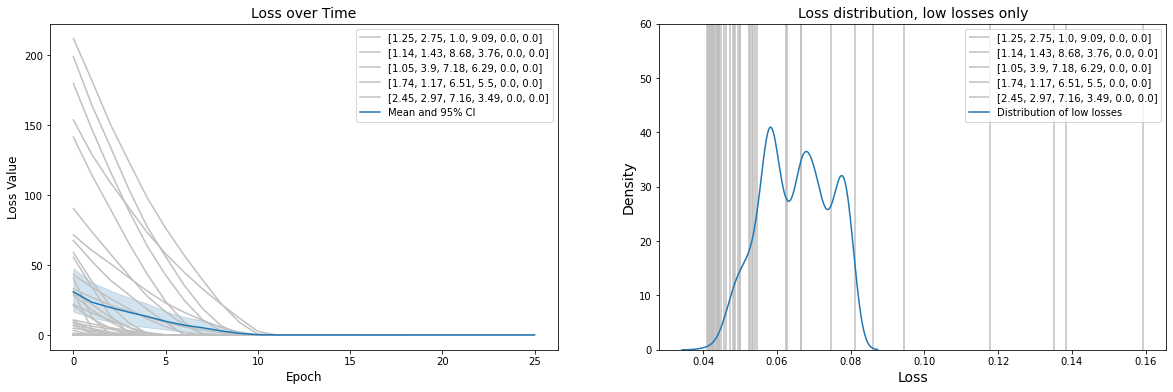

In [69]:
true_landscape = pd.read_csv('../6d_loss_landscape/6d_landscape_sundials.csv')

landscape = true_landscape.loc[true_landscape.theta1 != 100].loc[true_landscape.theta2 != 100]
min_loss = landscape.loss.min()
tolerance = 0.04

low_loss = landscape.loc[landscape.loss < min_loss + tolerance]
min_loss_landscape = landscape.loc[landscape.loss == min_loss]

ci_losses = []
ci_epochs = []
for df in list_of_results: 
    loss = df.loss.to_list()
    epochs = df.index.to_list()
    ci_losses = ci_losses + loss
    ci_epochs = ci_epochs + epochs
ci_df = pd.DataFrame({'loss': ci_losses, 'epoch':ci_epochs})

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

endpoint = 'Loss over Time'
ax = axs[0]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.plot(df.loss, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.plot(df.loss, color='silver')
sns.lineplot(data=ci_df, x="epoch", y="loss", label='Mean and 95% CI',ax=ax)
ax.legend()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss Value', fontsize=12)


endpoint = 'Loss distribution, low losses only'
ax = axs[1]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver')
    
sns.kdeplot(low_loss.loss, ax=ax, label='Distribution of low losses')

ax.set_ylim([0, 60])
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Loss', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
fig.savefig('init_losses_dc_n50.png')
